# IMDB movie reviews classification - Part 2

## What about using more powerful stuff this time?

In the previous post about IMDB movie reviews classification, we used a linear model to classify movie reviews. We achieved 87% accuracy on the test set, which is already great. However, we saw that this linear model was based on bags of words and hence was enable to capture the syntax of our reviews. As a result, and knowing that Neural Networks have set new benchmarks in Natural Language Processing tasks in recent years, is there a way to improve our classification performance? 

The purpose of this post is to take the same data set but to apply a whole different set of Natural Language Processing tools: Neural Networks. 

## 1. Load Data 

As before, the reviews data come from the keras datasets. We will also use keras to build our Neural Networks.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from gensim.models import Word2Vec

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Conv1D, Dense, Dropout, Embedding, Flatten, GlobalAveragePooling1D, GlobalMaxPooling1D, GRU, LSTM, MaxPooling1D

In [2]:
vocab_size = 3000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)
word_to_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


## 2. Reformating the reviews

### Tokenizing

As we saw in the previous post, there is not much data preparation to be done here because this Keras package does most of the work for us beforehand. As can be seen below, the tokenizing step has already been done for us by Keras (nice!), which means that words have been converted to numbers. 

In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


If you want to circle back to the actual words of these reviews, they are all stored in the word_to_index dictionary. This is how you can convert the tokenized version of the reviews back to actual text.

In [0]:
word_to_index = dict([(key,(value+3)) for key,value in word_to_index.items()]) 
word_to_index["<PAD>"] = 0
word_to_index["<START>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = dict([(value, key) for (key, value) in word_to_index.items()])

def to_words(review):
  return [index_to_word[i] for i in review]

In [5]:
print('label: %s' % train_labels[0])
print('review: %s' % ' '.join(to_words(train_data[0])))

label: 1
review: <START> this film was just brilliant casting location scenery story direction <UNK> really <UNK> the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same <UNK> island as myself so i loved the fact there was a real connection with this film the witty <UNK> throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really <UNK> at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of <UNK> and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what

### Padding

Don't be upset about all the UNK tags that you can see, this is just because we limited the vocabulary size to 3000 when we loaded the data. UNK basically means that it would have been a rare word or a name (there are lots of actors names in the reviews as you can imagine).

The data exploration part done in the previous post had shown us that the length of the reviews are varying a lot. This is an issue for the algorithms we want to use here, as they need all text inputs to have the same number of words. We can get around this issue thanks to padding. Padding essentially just ensures each list of tokens has the same length by either truncating or adding 0's at the end of the review. Note that 0 corresponds to 'PAD' in the word_to_index dictionary we have defined above!

When using the bag of words in our previous post, we restrained ourselves to the first 500 words. To ensure a fair comparison, let us use padding here with the same cap.

In [0]:
max_len = 500

train_data_padded = pad_sequences(train_data, maxlen=max_len, padding='post')
test_data_padded = pad_sequences(test_data, maxlen=max_len, padding='post')

Now we're all set for the modeling part!

## 3. Classification with Neural Networks

When building a Neural Network for Natural Language Processing, it is important to keep in mind that there are two steps:

- First, the text gets converted to Embeddings. In other words, each word gets assigned a vector, and a sentence (in our case, a review) gets represented by a matrix which is the concatenation of all these vectors
- These embeddings are then connected to a Neural Network with hidden layers

Embeddings play a key role in NLP models. There are many differences with the vectorized Bag of Words we saw in the previous post. To keep it short, the main advantage is that it should be able to capture semantics by representing each word in a vector space. However, the main drawback is that they require to learn a lot of parameters and a lot of data to do so. Suppose we want to have an embedding size of 32 and 3,000 words in our vocabulary, this implies we will have to learn 96,000 parameters. This is not an issue per se, as a matter of fact, it is still reasonable compared to other mainstream neural networks. However, it means we need a lot of data to train these embeddings accurately. As a result, there are two ways to go at this stage:

- Either you want to train your own embeddings from scratch...
- Or you use routines like Word2Vec to generate embeddings and feed your neural network with these 

The latter has grown widely popular as it usually saves time and... because it's a fancier. But let us check for ourselves if it really adds anything here...



### Learning Embeddings from scratch



Let us start with the first option, which is basically having the embeddings learned by the neural network before the dense layers. 

First, we set our embeddings to have a size of 32, which means that each word will be represented by a vector of 32 values. We will run our network on 10 epochs, which means that each review will be passed to the model 10 times during the training phase. We set the batch size to be 128, which means the parameters will be updated for batches of 128 reviews at a time in each epoch.

In [0]:
embedding_size = 32
epochs = 10
batch_size = 128

Let us go through the model below step by step. 

- First, we define the Embedding layer. It has to learn $32 \times 3000 = 96000 $ parameters, because each word gets represented by a vector of 32 elements. After a review passes through this layer, it is a matrix of size (500,32) because it concatenates the embeddings of each word of the review (we set the length of each review to be 500 words when we padded the reviews!)
- We then compute the average of this matrix on each of the 32 embedding dimensions. This step aims to reduce the dimensionality of our reviews by aggregating information. In the deep learning jargon, this is called "Pooling". At this stage, the review is now summarized in a vector of 32 values.
- These values are connected to 64 hidden nodes with linear transformations on each edge of this dense graph ($y = w.x+b$). As a result, there are $64 \times 32 = 2048$ weights to learn and 64 biases. Hence, there are 2112 parameters to be trained at this stage
- Each of the 64 nodes get applied a non-linear function, relu
- We then randomly discard 50% of these nodes, which is called "Dropout". Dropout is a highly efficient step to avoid overfitting.
- Finally, we connect our remaining nodes to the output node, with the same linear transformations as before. So this time, there will be $1\times64 + 1 = 65$ parameters to train.
- Finally, our output gets tranformed to a probability value thanks to the sigmoid function. This probability will represent the probability of being a positive value (the probability of being a negative review will simply be 1 - that)

In [7]:
model_base = Sequential()
model_base.add(Embedding(vocab_size, embedding_size, input_shape=(max_len,)))
model_base.add(GlobalAveragePooling1D())
model_base.add(Dense(64, activation='relu'))
model_base.add(Dropout(rate = 0.5))
model_base.add(Dense(1, activation='sigmoid'))
model_base.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           96000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 98,177
Trainable params: 98,177
Non-trainable params: 0
_________________

This sums up to 98,177 parameters to train. As you can see, the majority of them come from the embedding step... Let us see how this model performs now!

In [8]:
history = model_base.fit(train_data_padded, train_labels, epochs=epochs, batch_size = batch_size, validation_split = 0.25)

Instructions for updating:
Use tf.cast instead.
Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 4s 199us/step - loss: 0.6833 - acc: 0.5879 - val_loss: 0.6472 - val_acc: 0.7504
Epoch 2/10
18750/18750 [==============================] - 1s 63us/step - loss: 0.5464 - acc: 0.7765 - val_loss: 0.4323 - val_acc: 0.8482
Epoch 3/10
18750/18750 [==============================] - 1s 63us/step - loss: 0.3761 - acc: 0.8554 - val_loss: 0.3443 - val_acc: 0.8653
Epoch 4/10
18750/18750 [==============================] - 1s 64us/step - loss: 0.3161 - acc: 0.8761 - val_loss: 0.3143 - val_acc: 0.8755
Epoch 5/10
18750/18750 [==============================] - 1s 63us/step - loss: 0.2849 - acc: 0.8885 - val_loss: 0.3054 - val_acc: 0.8781
Epoch 6/10
18750/18750 [==============================] - 1s 64us/step - loss: 0.2632 - acc: 0.8985 - val_loss: 0.2961 - val_acc: 0.8816
Epoch 7/10
18750/18750 [==============================] - 1s 64us/step - loss: 0

Text(0.5, 1.0, 'Accuracy and loss on the training and validation set')

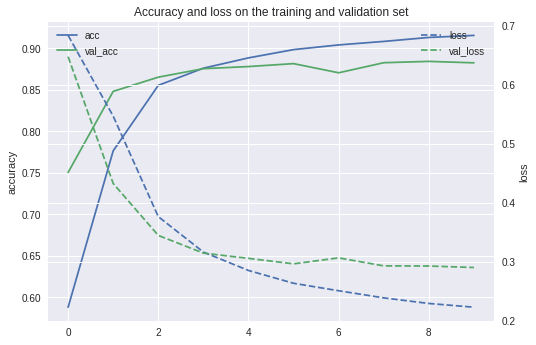

In [9]:
df = pd.DataFrame(history.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
ax = plt.twinx()
df[['loss', 'val_loss']].plot(linestyle='--', ax=ax)
ax.legend(loc = 1)
plt.ylabel("loss")
plt.title("Accuracy and loss on the training and validation set")

We achieve around 88% accuracy on the validation score with this method. Neat isn't it? We already outperformed the linear model from the previous step a bit!

### Using Word2Vec Embeddings

As stated above, another option is to use embeddings that would be computed before feeding the reviews to our neural network. A famous option to achive this is using Word2Vec. We will not cover how Word2Vec works here as it would make things quite long... Let us just use cover how to use them and assess what they bring to our problem.

It's quite easy, all you need to do is run this! Size will specify the embedding size (it is the same as before) and window can be seen as how many neighbour words are going to be considered when training the embeddings.

In [0]:
w2v_embeddings = Word2Vec(sentences = [to_words(review) for review in train_data], size = embedding_size, window = 5)

As mentioned before, Word2Vec is quite fancy, which is also what makes it popular. For instance, you can check what words are most similar in the way they are used. This works by simply computing the cosine between each embedding and keeping the maximum value. You can see this as a dot product that evaluates how similar two vectors are..

In [27]:
w2v_embeddings.wv.most_similar("movie", topn = 3)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('film', 0.9342168569564819),
 ('sequel', 0.7790613770484924),
 ('show', 0.7621879577636719)]

For instance, the word closest to "movie" is "film" (the numeric value is the cosine score). This highlights the power of embeddings. Compare this to the Bag of Words methodology we saw previously, where "film" and "movie" would be treated as two different words. Here, given that their embeddings are similar, they will be treated in a similar way too. This makes a lot of sense!

Some more playing around with Word2Vec. For instance, suppose I write the following review: "I loved this movie because it has great actors and a great castle" because I did a typo and wrote castle instead of cast (or say my automatic correcter did that...). Can embeddings help us to see there is something wrong?

In [35]:
w2v_embeddings.wv.doesnt_match("I loved this movie because it has great actors and a great castle".split())

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'castle'

Oh yes it can! It correctly identified "castle" as being the outlier here. How did it do that? Simply by computing the average embedding of my review and by identifying that "castle" had the smallest cosine score (smallest similiarity) with this average. Nice!

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_shape=(max_len,)))
model.add(Dropout(0.4))
model.add(Conv1D(filters = 256, kernel_size = 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(rate = 0.5))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(train_data_padded, train_labels, epochs=10, batch_size = batch_size, validation_split=0.25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           96000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 496, 256)          41216     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total para

Text(0.5, 1.0, 'Accuracy and loss on the training and validation set')

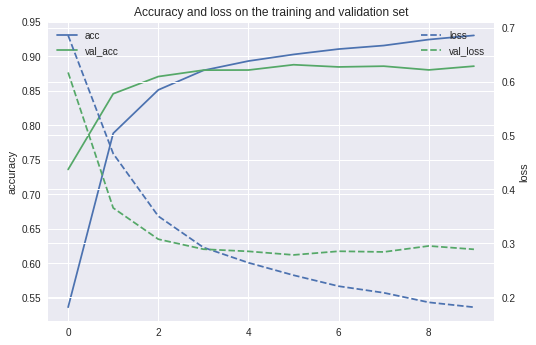

In [0]:
df = pd.DataFrame(history.history)
df[['acc', 'val_acc']].plot()
plt.ylabel("accuracy")
ax = plt.twinx()
df[['loss', 'val_loss']].plot(linestyle='--', ax=ax)
ax.legend(loc = 1)
plt.ylabel("loss")
plt.title("Accuracy and loss on the training and validation set")